<a href="https://colab.research.google.com/github/god05212/NLP/blob/main/NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 사용한 데이터셋
> Fake and real news dataset: Classifying the news
- Clément Bisaillon
- https://www.kaggle.com/clmentbisaillon
- https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset

# Reading the Dataset

In [1]:
from google.colab import files
updloaded = files.upload()

Saving Fake.csv to Fake.csv
Saving True.csv to True.csv


In [2]:
import pandas as pd
df_true = pd.read_csv("True.csv")
df_fake = pd.read_csv("Fake.csv")

> target 변수를 설정하고 진짜 및 가짜 뉴스 데이터 세트를 모두 결합합니다.

In [14]:
df_true['target'] = 1
df_fake['target'] = 0
df = pd.concat([df_true, df_fake]).reset_index(drop = True)
df['original'] = df['title'] + ' ' + df['text']
df

,title,text,subject,date,target,original
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1,"As U.S. budget fight looms, Republicans flip t..."
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1,U.S. military to accept transgender recruits o...
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1,Senior U.S. Republican senator: 'Let Mr. Muell...
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1,FBI Russia probe helped by Australian diplomat...
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1,Trump wants Postal Service to charge 'much mor...
...,...,...,...,...,...,...
44893,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016",0,McPain: John McCain Furious That Iran Treated ...
44894,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016",0,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...
44895,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016",0,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...
44896,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016",0,How to Blow $700 Million: Al Jazeera America F...


> 데이터의 null 값을 확인합니다.

In [4]:
df.isnull().sum()

title       0
text        0
subject     0
date        0
target      0
original    0
dtype: int64

# Data Cleaning

> 텍스트 데이터에는 종종 우리에게 아무런 도움이 되지 않을 수 있는 구성요소가 존재합니다. 이 섹션의 주요 목표는 보다 원활한 분석을 위해 이러한 구성 요소를 제거하는 것입니다. 제공된 데이터에서 불용어(Stopwords)를 제거하는 기능을 만들 계획입니다. 분석 및 예측 중에 필요한 경우 이 기능을 사용할 것입니다.

In [12]:
import nltk
nltk.download('stopwords')
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 2 and token not in stop_words:
            result.append(token)
            
    return result
# 일치하지 않는 제목을 동일한 표기법으로 변환합니다
df.subject=df.subject.replace({'politics':'PoliticsNews','politicsNews':'PoliticsNews'})

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Exploratory Data Analysis

> 진짜 뉴스와 가짜 뉴스 사이의 주제 확인

In [15]:
sub_tf_df=df.groupby('target').apply(lambda x:x['title'].count()).reset_index(name='Counts')
sub_tf_df.target.replace({0:'False',1:'True'},inplace=True)
fig = px.bar(sub_tf_df, x="target", y="Counts",
             color='Counts', barmode='group',
             height=400)
fig.show()

> 데이터 셋이 균형 잡힌 것처럼 보이기 때문에 균형 있게 만들기 위해 노력할 필요가 없습니다.

> 어떤 주제가 많나 확인해보겠습니다.

In [16]:
sub_check=df.groupby('subject').apply(lambda x:x['title'].count()).reset_index(name='Counts')
fig=px.bar(sub_check,x='subject',y='Counts',color='Counts',title='Count of News Articles by Subject')
fig.show()

> PoliticalNews와 WorldNews가 데이터 셋에서 가장 많은 지배적인 카운트를 보유하고 있습니다.

> 뉴스 헤드라인이 뉴스가 가짜인지 아닌지를 예측하기에 충분할까? 다음 분석에서 확인할 수 있습니다.

In [17]:
df['clean_title'] = df['title'].apply(preprocess)
df['clean_title'][0]

['budget', 'fight', 'looms', 'republicans', 'flip', 'fiscal', 'script']

In [18]:
df['clean_joined_title']=df['clean_title'].apply(lambda x:" ".join(x))

> 제목에 대한 Word Cloud를 살펴보도록 하겠습니다.
진짜 뉴스 헤드라인을 사용하여 Word Cloud를 확인합니다.

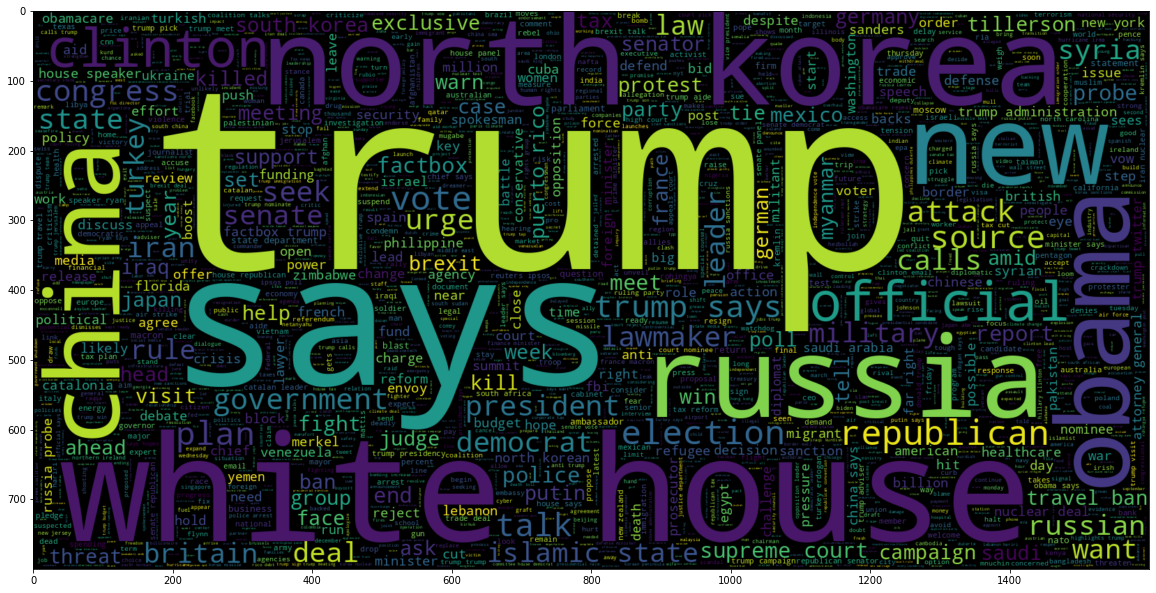

In [19]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stop_words).generate(" ".join(df[df.target == 1].clean_joined_title))
plt.imshow(wc, interpolation = 'bilinear')

> 가짜 뉴스 헤드라인을 사용하여 Word Cloud를 확인합니다.

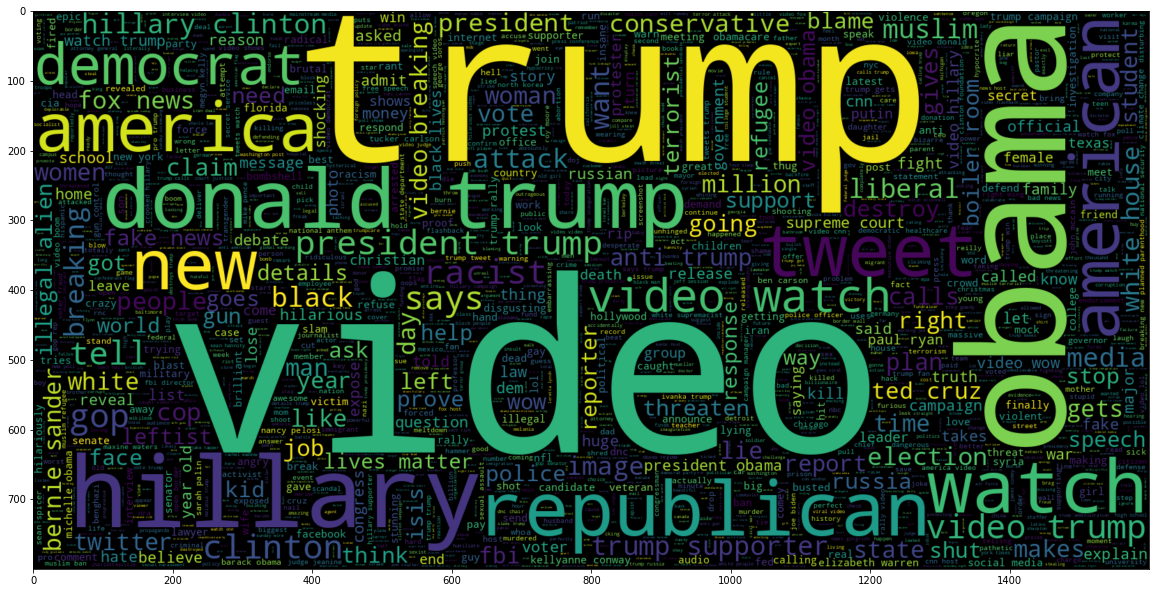

In [20]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stop_words).generate(" ".join(df[df.target == 0].clean_joined_title))
plt.imshow(wc, interpolation = 'bilinear')

> 제목에 있는 단어 수 분포를 살펴보겠습니다.

In [21]:
maxlen = -1
for doc in df.clean_joined_title:
    tokens = nltk.word_tokenize(doc)
    if(maxlen<len(tokens)):
        maxlen = len(tokens)
print("The maximum number of words in a title is =", maxlen)
fig = px.histogram(x = [len(nltk.word_tokenize(x)) for x in df.clean_joined_title], nbins = 50)
fig.show()

The maximum number of words in a title is = 34


> 평균적으로 최대 제목 수는 7-8단어 사이입니다. 이 몇 마디 말만으로 뉴스가 사실인지 가짜인지 판단하기가 좀 어려울 것 같습니다. 그래서 우리는 제목만으로 많은 정확성을 얻지 못할 것 같습니다. 그럼 이제 예측으로 넘어가겠습니다.

In [22]:
X_train, X_test, y_train, y_test = train_test_split(df.clean_joined_title, df.target, test_size = 0.2,random_state=2)
vec_train = CountVectorizer().fit(X_train)
X_vec_train = vec_train.transform(X_train)
X_vec_test = vec_train.transform(X_test)

In [23]:
model = LogisticRegression(C=2)
model.fit(X_vec_train, y_train)
predicted_value = model.predict(X_vec_test)
accuracy_value = roc_auc_score(y_test, predicted_value)
print(accuracy_value)

0.947466974653341


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

